# 🐋 Whale Vocal Interaction Analysis (Fully Commented)
This notebook analyzes whale vocal interactions using network science and dyadic statistics. Each step is heavily commented to explain exactly what the code is doing.

## 📦 Step 1: Import Required Libraries

In [1]:
# pandas for data handling
# networkx for building and analyzing networks
# matplotlib and seaborn for visualizations
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

## 📂 Step 2: Load the Dataset

In [2]:
# Load the CSV file containing whale vocalization data
# Replace missing call types (NaN) with 'InitiationCall' since that's how initiation is recorded
df = pd.read_csv("PrepData.csv")
df["CallType"] = df["CallType"].fillna("InitiationCall")

## 🔄 Step 3: Build Interaction Networks

In [3]:
# Initialize dictionaries to store the graph and centrality results per group
group_graphs = {}
group_central_whales = {}

# Loop through each whale group (G1, G2, G3)
for group_id, df_group in df.groupby("Group"):
    # Remove rows missing WhaleID or CallType
    df_group_clean = df_group.dropna(subset=["WhaleID", "CallType"])

    edge_counts = Counter()

    # Group by 'bout' to identify interaction episodes
    for bout_id, group in df_group_clean.groupby("bout"):
        group_sorted = group.sort_values("StartTime")

        # Identify the initiator of the bout
        initiator_row = group_sorted[group_sorted["CallType"] == "InitiationCall"]
        responders = group_sorted[group_sorted["CallType"] == "ResponseCall"]

        # Add edges from the initiator to each responder in the same bout
        if not initiator_row.empty:
            initiator = initiator_row.iloc[0]["WhaleID"]
            for _, responder_row in responders.iterrows():
                responder = responder_row["WhaleID"]
                if pd.notna(responder) and initiator != responder:
                    edge_counts[(initiator, responder)] += 1

    # Build a directed graph and add weighted edges
    G = nx.DiGraph()
    for (u, v), w in edge_counts.items():
        G.add_edge(u, v, weight=w)

    group_graphs[group_id] = G

    # Compute node strengths (total in + out weights) for centrality
    node_strength = {}
    for node in G.nodes():
        in_strength = sum(G[u][node]['weight'] for u in G.predecessors(node))
        out_strength = sum(G[node][v]['weight'] for v in G.successors(node))
        node_strength[node] = in_strength + out_strength

    # Identify the most central whale (highest total strength)
    central_whale = max(node_strength, key=node_strength.get) if node_strength else None
    group_central_whales[group_id] = (node_strength, central_whale)

## 🎯 Step 4: Visualize Interaction Networks

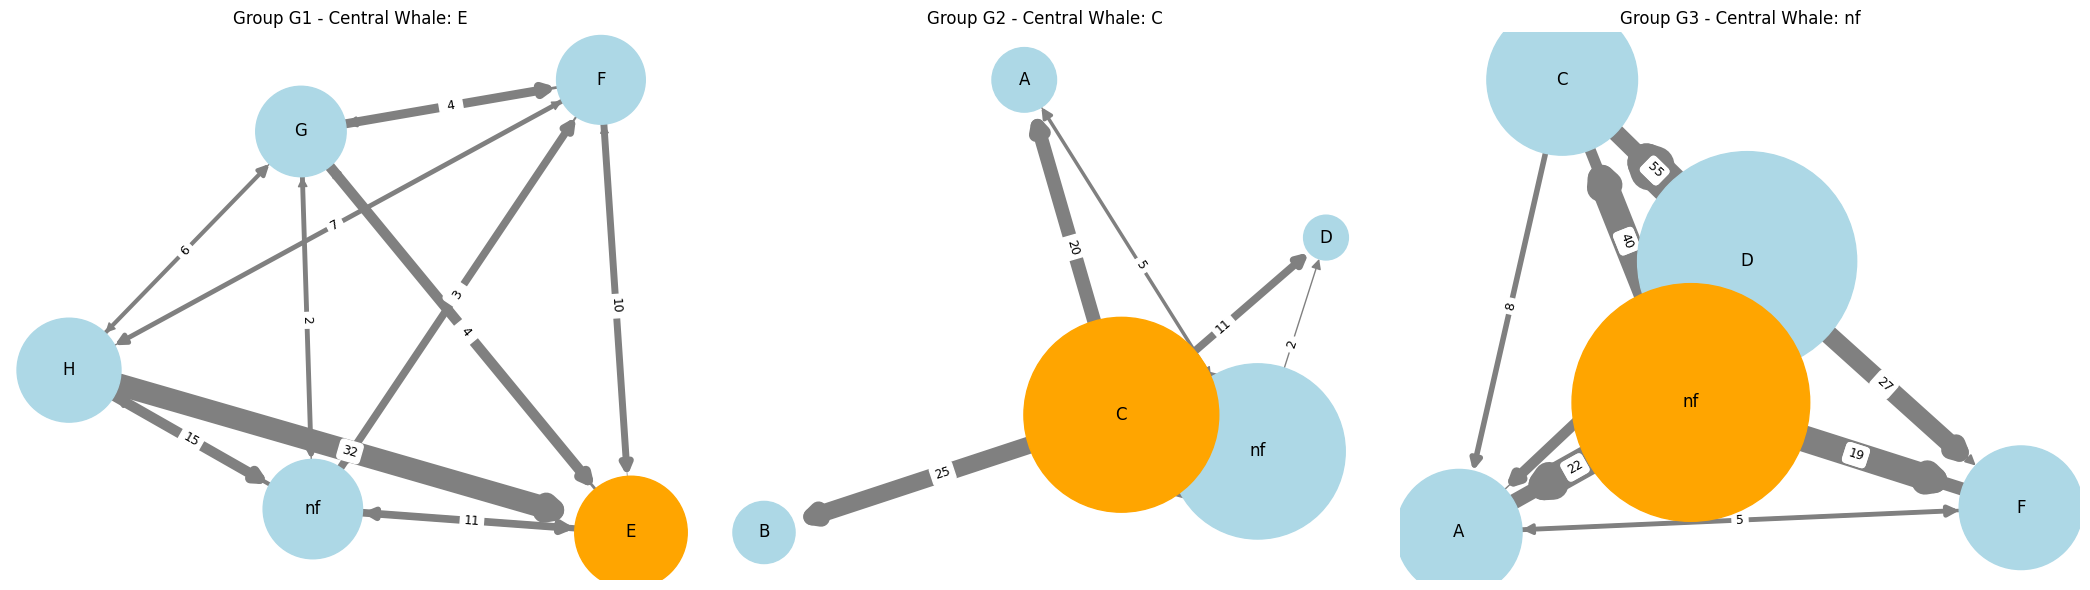

In [4]:
# Draw each group's network
# Node size reflects total strength, orange node is the most central whale
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, (group_id, G) in zip(axes, group_graphs.items()):
    strength_dict, central_whale = group_central_whales[group_id]
    # Use spring layout and space nodes out more for clarity (k controls spacing)
    k_value = 1.2 if group_id == "G1" else 2.5
    pos = nx.spring_layout(G, seed=42, k=k_value)

    node_sizes = [strength_dict.get(node, 1) * 80 for node in G.nodes()]
    node_colors = ['orange' if node == central_whale else 'lightblue' for node in G.nodes()]
    weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes,
            edge_color='gray', width=weights, arrowsize=15, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=9)
    ax.set_title(f"Group {group_id} - Central Whale: {central_whale}")

plt.tight_layout()
plt.show()